In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

D:\Users\Yue\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import sys
sys.path.append("..")
from optimizer import NormalizedOptimizer
from utils import callbacks

Using TensorFlow backend.


In [4]:
from keras.optimizers import Adam
from keras import backend as K

In [5]:
sess = tf.InteractiveSession()
K.set_session(sess)

# Code from [kmkolasinski/deep-learning-notes](https://github.com/kmkolasinski/deep-learning-notes/blob/master/max-normed-optimizer/notebooks/Keras_MLP_test.ipynb)

# Dataset Loading

In [6]:
from keras.datasets import mnist
from keras.utils import to_categorical
num_classes = 10
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train = x_train.reshape([-1, 28**2])
x_test = x_test.reshape([-1, 28**2])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Model Definition

In [7]:
from keras.models import Model
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from keras.regularizers import l2

In [9]:
NUM_LAYERS = 30
L2_REG = 1e-5
HIDDEN_DIM = 128
ACTIVATION = 'relu'
DROPOUT_PROB = 0.2

CHANNEL_AXIS = 1 if K.image_data_format() == 'channels_first' else -1
BATCHSIZE = 128

In [10]:
def generate_model(num_layers=NUM_LAYERS, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, dropout=DROPOUT_PROB):
    ip = Input(shape=(28 * 28,))
    x = ip
    
    for i in range(num_layers):
        x = Dense(hidden_dim, activation=activation, kernel_regularizer=l2(L2_REG), kernel_initializer='he_normal')(x)
        x = BatchNormalization(axis=CHANNEL_AXIS)(x)
        x = Dropout(dropout)(x)
        
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, x)
    
    return model

In [11]:
model = generate_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

# Train with Normalized SGD

In [12]:
from keras.optimizers import Adam, SGD, RMSprop

In [13]:
model = generate_model()
metrics_history = [callbacks.AggregateMetricsOnBatchEnd(), callbacks.AggregateMetricsOnEpochEnd()]

for lr in [0.01, 0.001, 0.0001]:
    optimizer = NormalizedOptimizer(SGD(lr, momentum=0.9, nesterov=True), normalization='max')
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, 
        batch_size=BATCHSIZE, epochs=10, 
        validation_data=(x_test, y_test), 
        callbacks=metrics_history)


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 39s 652us/step - loss: 1.8079 - acc: 0.3579 - val_loss: 1.4617 - val_acc: 0.4698
Epoch 2/10
60000/60000 [==============================] - 35s 578us/step - loss: 1.4612 - acc: 0.4451 - val_loss: 1.5221 - val_acc: 0.4135
Epoch 3/10
60000/60000 [==============================] - 35s 577us/step - loss: 1.3923 - acc: 0.4579 - val_loss: 1.3030 - val_acc: 0.4833
Epoch 4/10
60000/60000 [==============================] - 34s 571us/step - loss: 1.3585 - acc: 0.4630 - val_loss: 1.3407 - val_acc: 0.4774
Epoch 5/10
60000/60000 [==============================] - 34s 566us/step - loss: 1.2765 - acc: 0.5267 - val_loss: 1.1677 - val_acc: 0.5564
Epoch 6/10
60000/60000 [==============================] - 34s 570us/step - loss: 1.2540 - acc: 0.5339 - val_loss: 2.1730 - val_acc: 0.3886
Epoch 7/10
60000/60000 [==============================] - 34s 567us/step - loss: 1.2773 - acc: 0.5511 - val_loss: 1.

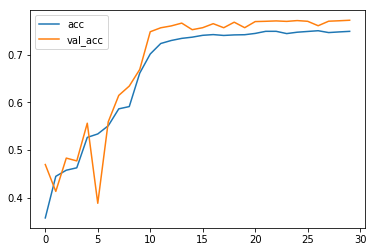

In [14]:
hist = metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Train with Normalized Adam

In [15]:
model = generate_model()
adam_metrics_history = [callbacks.AggregateMetricsOnBatchEnd(), callbacks.AggregateMetricsOnEpochEnd()]

for lr in [0.01, 0.001, 0.0001]:
    optimizer = NormalizedOptimizer(Adam(lr), normalization='max')
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, 
        batch_size=BATCHSIZE, epochs=10, 
        validation_data=(x_test, y_test), 
        callbacks=adam_metrics_history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 48s 797us/step - loss: 1.7003 - acc: 0.4641 - val_loss: 1.5836 - val_acc: 0.7111
Epoch 2/10
60000/60000 [==============================] - 40s 665us/step - loss: 1.2593 - acc: 0.6511 - val_loss: 1.1964 - val_acc: 0.6969ETA: 16s - loss: 1.2578 - acc: 0.6532 - ETA: 10s - loss: 1.2565 - acc: 0.6551
Epoch 3/10
60000/60000 [==============================] - 40s 661us/step - loss: 1.1555 - acc: 0.6850 - val_loss: 1.0063 - val_acc: 0.7581ETA: 3s - loss: 1.1594 - acc: 0.6840
Epoch 4/10
60000/60000 [==============================] - 40s 660us/step - loss: 1.1052 - acc: 0.7056 - val_loss: 1.1009 - val_acc: 0.7226
Epoch 5/10
60000/60000 [==============================] - 40s 663us/step - loss: 1.0911 - acc: 0.7068 - val_loss: 0.9445 - val_acc: 0.7540
Epoch 6/10
60000/60000 [==============================] - 40s 659us/step - loss: 1.0500 - acc: 0.7263 - val_loss: 1.0257 - val_acc: 0.7341
Epo

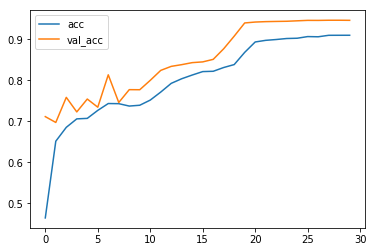

In [23]:
hist = adam_metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Train with normalized RMSProp

In [19]:
model = generate_model()
rmsprop_metrics_history = [callbacks.AggregateMetricsOnBatchEnd(), callbacks.AggregateMetricsOnEpochEnd()]

for lr in [0.01, 0.001, 0.0001]:
    optimizer = Adam(lr)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, 
        batch_size=BATCHSIZE, epochs=10, 
        validation_data=(x_test, y_test), 
        callbacks=rmsprop_metrics_history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 57s 947us/step - loss: 2.2392 - acc: 0.1942 - val_loss: 2.0093 - val_acc: 0.4033
Epoch 2/10
60000/60000 [==============================] - 40s 662us/step - loss: 1.3933 - acc: 0.5049 - val_loss: 0.9308 - val_acc: 0.6756
Epoch 3/10
60000/60000 [==============================] - 40s 665us/step - loss: 1.0755 - acc: 0.6638 - val_loss: 0.7486 - val_acc: 0.7527ETA: 23s - loss: 1.1285 - acc: 0.6380
Epoch 4/10
60000/60000 [==============================] - 39s 656us/step - loss: 0.9902 - acc: 0.7083 - val_loss: 0.9067 - val_acc: 0.7236
Epoch 5/10
60000/60000 [==============================] - 40s 658us/step - loss: 0.9189 - acc: 0.7331 - val_loss: 0.6865 - val_acc: 0.8183
Epoch 6/10
60000/60000 [==============================] - 40s 662us/step - loss: 0.9708 - acc: 0.7263 - val_loss: 0.9390 - val_acc: 0.7574
Epoch 7/10
60000/60000 [==============================] - 39s 657us/step - loss

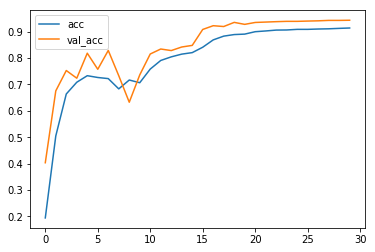

In [20]:
hist = rmsprop_metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

In [32]:
from collections import OrderedDict
hist = OrderedDict()
hist['NSGD'] = metrics_history
hist['NADAM'] = adam_metrics_history
hist['momentum'] = rmsprop_metrics_history

def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

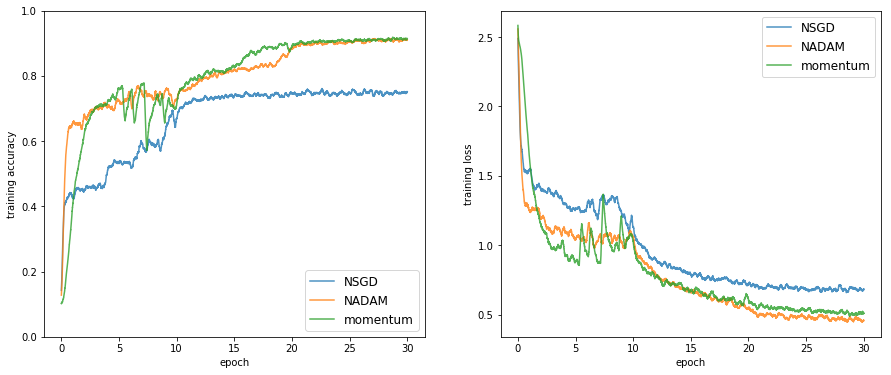

In [33]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
for opt, hist in hists.items():
    h = hist[0].monitor_values['accuracies']['acc']
    h = moving_average(h, periods=100)
    step_to_epoch = np.linspace(0, 30, len(h))
    plt.plot(step_to_epoch, h, label=opt, alpha=0.8)
plt.ylim([0, 1])
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('epoch')
plt.ylabel('training accuracy')

plt.subplot(122)
for opt, hist in hists.items():
    h = hist[0].monitor_values['losses']['loss']
    h = moving_average(h, periods=100)
    step_to_epoch = np.linspace(0, 30, len(h))
    plt.plot(step_to_epoch, h, label=opt, alpha=0.8)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('training loss')

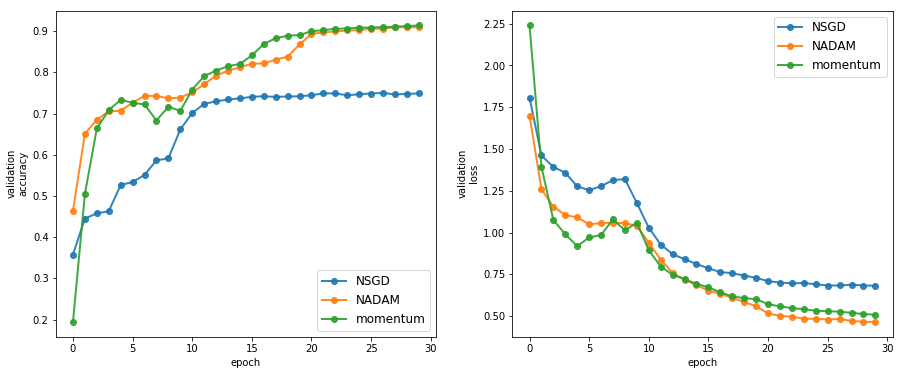

In [34]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
for opt, hist in hists.items():
    h = hist[1].monitor_values['accuracies']['acc']
    plt.plot(h, 'o-',label=opt,  alpha=0.9, linewidth=2)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('epoch')
plt.ylabel('validation\naccuracy')

plt.subplot(122)
for opt, hist in hists.items():
    h = hist[1].monitor_values['losses']['loss']
    plt.plot(h, 'o-', label=opt,  alpha=0.9, linewidth=2)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('validation\nloss')